The purpose of this notebook is to quickly model how the water potential varies up the trunk, assumig a single non-branching trunk.

In [52]:
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution
from profit_optimisation_model.src.HydraulicConductanceModels.cumulative_Weibull_distribution_model import cumulative_Weibull_distribution_parameters_from_conductance_loss

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import copy as cp

# Model setup
First let us set up the properties of the system and the different arrays needed to hold the data.

In [2]:
p50 = -3.
p88 = -4.
k_max = 1.

# Calcualte the shape and scale parameters for the Weibull distribution
k_max, shape, scale = cumulative_Weibull_distribution_parameters_from_conductance_loss(k_max, p50, p88, 0.5, 0.88)

N_points = 1000

# Set up an array to hold the height of each point
hights = np.linspace(0, 100, N_points + 2)


# Model run
The transpiration across any given section must be constant through the system.

$$
E_{n, n+1} = k_{n, n+1} (\psi_{n+1} - \psi_{n})
$$

For suficently small $\Delta \psi$ we can approximate the conductance $k_{n, n+1}$ as the conductance at the mean of the two water potentials.

$$
k_{n, n+1} = k(\text{mean}(\psi_{n}, \psi_{n+1}))
$$

Given that the transpiration is equal for all sections we can write the following;

$$
k_{n, n+1}( \psi_{n+1} - \psi_{n}) = k_{n-1, n}( \psi_{n} - \psi_{n-1})
$$

Re-arranging the equation we get a value for the water potential at point $n$;

$$
\psi_{n} = \frac{\psi_{n-1}k_{n-1,n} + \psi_{n+1}k_{n,n+1}}{k_{n-1,n} + k_{n,n+1}}
$$

We can iteratively solve for the water potential and the conductance, holding the soil and lea water potentials at each end constant, until we reach equilibrium. This should give us the water potential at each point along the trunk.

In [3]:
def calc_height_dependencies(psi_root, psi_leaf, N_points, k_max, shape, scale, 
                             N_steps=1000000, tolerance=1e-8):
    
    psi_current = np.linspace(psi_root, psi_leaf, N_points + 2)

    psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
    k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
    
    E_current = k_current * (psi_current[1:] - psi_current[:-1])
    
    i = 0
    
    for i in range(N_steps):
        # Update the water potential at each point
        psi_current[1:-1] = (psi_current[:-2] * k_current[:-1] + psi_current[2:] * k_current[1:]) / (k_current[:-1] + k_current[1:])
        
        # Update the conductance between each point
        psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
        k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
        
        # Update the transpiration between each point
        E_current = k_current * (psi_current[1:] - psi_current[:-1])
        
        # Check for convergence
        if np.all(np.abs(E_current[0] - E_current[-1]) < tolerance):
            break
            
    
    print('Finished at step', i, 'of', N_steps)
    
    return psi_current, k_current, E_current

psi_leaf = -5.
psi_root = -0.1

psi, k, E = calc_height_dependencies(psi_root, 
                                     psi_leaf, 
                                     N_points, 
                                     k_max, 
                                     shape, 
                                     scale)

Finished at step 999999 of 1000000


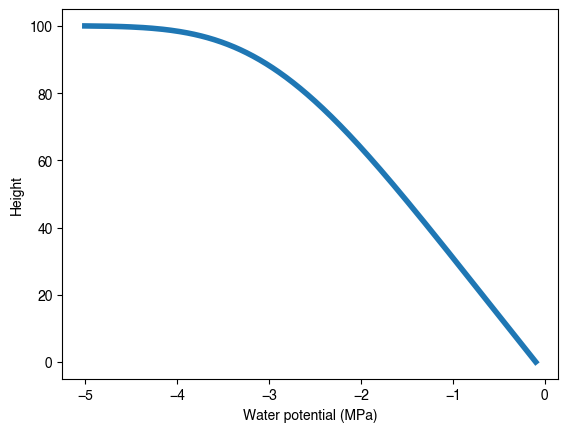

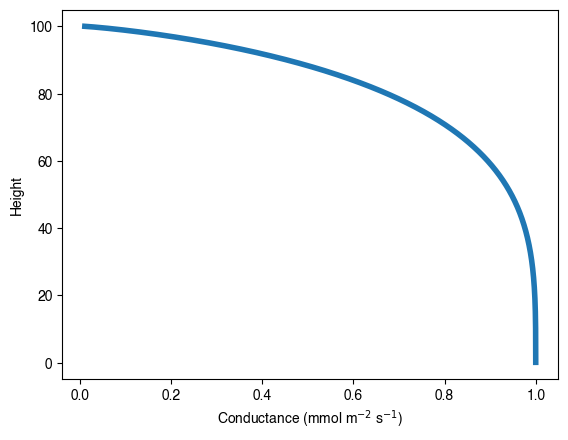

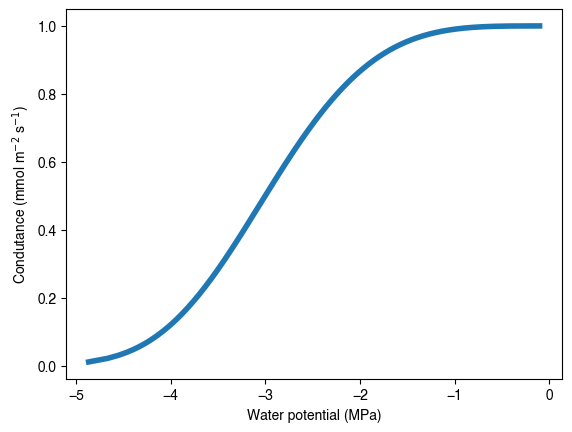

In [4]:
plt.plot(psi, hights, linewidth=4)
plt.ylabel('Height')
plt.xlabel('Water potential (MPa)')
plt.show()

plt.plot(k, hights[1:], linewidth=4)
plt.ylabel('Height')
plt.xlabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.show()

'''
plt.plot(E, hights[1:], linewidth=4)
plt.ylabel('Height')
plt.xlabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.show()
'''

plt.plot((psi[1:] + psi[:-1])/2, k, linewidth=4)
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.show()

# Changing the maximum conductance
Since shortening the length of the xylem changes its conductance we need to check if this would change how the water potential varies up the trunk.

In [5]:
k_max_list = [1., 2., 3.]

psi_leaf = -6.
psi_root = -0.1

psi = []
k = []
E = []

for k_max_current in k_max_list:
    psi_current, k_current, E_current = calc_height_dependencies(psi_root, 
                                                                 psi_leaf, 
                                                                 N_points, 
                                                                 k_max_current, 
                                                                 shape, 
                                                                 scale)
    psi.append(psi_current)
    k.append(k_current)
    E.append(E_current)
    


Finished at step 999999 of 1000000
Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


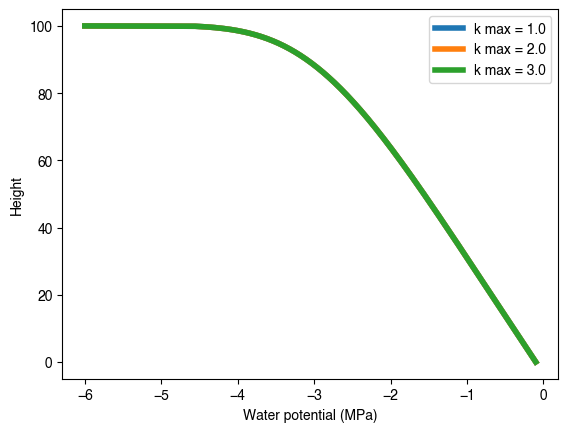

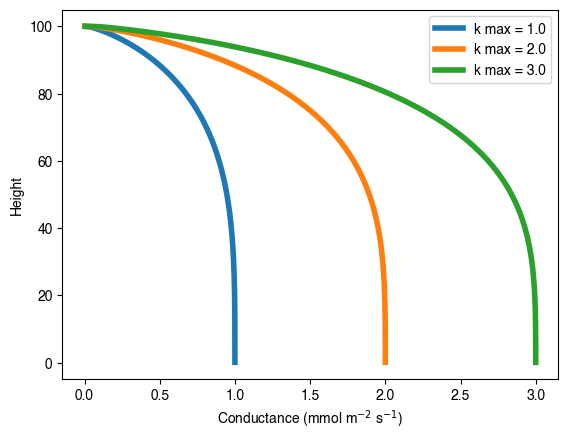

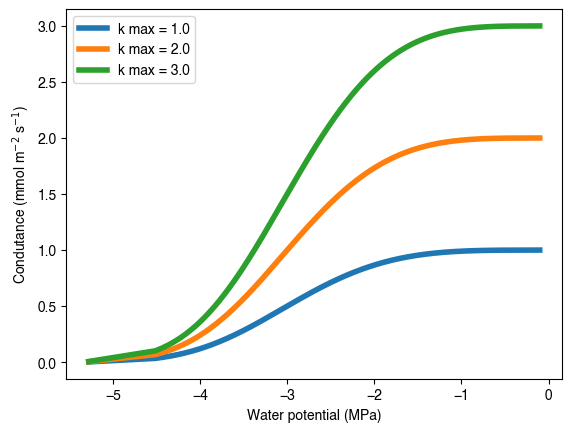

In [6]:
for i in range(len(psi)):
    plt.plot(psi[i], hights, label='k max = ' + str(k_max_list[i]), linewidth=4)
plt.ylabel('Height')
plt.xlabel('Water potential (MPa)')
plt.legend()
plt.show()

for i in range(len(k)):
    plt.plot(k[i], hights[1:], label='k max = ' + str(k_max_list[i]), linewidth=4)
plt.ylabel('Height')
plt.xlabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

'''
for i in range(len(E)):
    plt.plot(E[i], hights[1:], label='k max = ' + str(k_max[i]), linewidth=4)
plt.ylabel('Height')
plt.xlabel('Transpiration (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()
'''

for i in range(len(E)):
    plt.plot((psi[i][1:]+psi[i][:-1])/2, k[i], label='k max = ' + str(k_max_list[i]), linewidth=4)
plt.xlabel('Water potential (MPa)')
plt.ylabel('Condutance (mmol m$^{-2}$ s$^{-1}$)')
plt.legend()
plt.show()

We can see that changing the maximum conductance doesn't impact the water potential as a function of height up the tree. Further it only impacts the magnitude of the transpiration rate hence we don't need to worry about it.

# Impairing the conductance
To model xylem damage we fix the conductance at each height to the minimum of the current conductance and the previous minimum conductance.

In [7]:
def calc_height_dependencies_impaired_k(psi_root, psi_leaf, N_points, k_max, shape, scale, k_cap,
                                      N_steps=1000000, tolerance=1e-8):
    
    psi_current = np.linspace(psi_root, psi_leaf, N_points + 2)

    psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
    k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
    
    E_current = k_current * (psi_current[1:] - psi_current[:-1])
    
    i = 0
    
    for i in range(N_steps):
        # Update the water potential at each point
        psi_current[1:-1] = (psi_current[:-2] * k_current[:-1] + psi_current[2:] * k_current[1:]) / (k_current[:-1] + k_current[1:])
        
        # Update the conductance between each point
        psi_means_for_k = (psi_current[1:] + psi_current[:-1]) / 2
        k_current = cumulative_Weibull_distribution(psi_means_for_k, k_max, shape, scale)
        
        # Cap the conductance
        k_current = np.minimum(k_current, k_cap)
        
        # Calculate the transpiration between each point
        E_current = k_current * (psi_current[1:] - psi_current[:-1])
        
        # Check for convergence
        if np.all(np.abs(E_current[0] - E_current[-1]) < tolerance):
            break
            
    
    print('Finished at step', i, 'of', N_steps)
    
    return psi_current, k_current, E_current

In [8]:
def Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, psi_impaired, k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale, title = ''):
    # Plot vulnerability curves
    plt.plot(psi_healthy, k_healthy, label='Healthy', linewidth=4, zorder=1)
    plt.plot(psi_impaired, k_impaired, label='Impaired', linewidth=4, zorder=1)
    
    k_root = cumulative_Weibull_distribution(psi_rmin, k_max, shape, scale)
    k_leaf = cumulative_Weibull_distribution(psi_lmin, k_max, shape, scale)
    
    # Plot the conductance limits
    plt.axhline(k_root, label = '$k(\psi_{r min})$', color = 'black', linestyle='--', linewidth=2, zorder=0)
    plt.axhline(k_leaf, label = '$k(\psi_{l min})$', color = 'grey', linestyle='--', linewidth=2, zorder=0)
    
    # Plot the water potential limits
    plt.axvline(psi_r, label = '$\psi_r$', color = 'black', linestyle=':', linewidth=2, zorder=0)
    plt.axvline(psi_l, label = '$\psi_r$', color = 'grey', linestyle=':', linewidth=2, zorder=0)
    
    plt.xlabel('Water potential (MPa)')
    plt.ylabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
    plt.legend()
    plt.title(title)
    plt.show()
    

Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


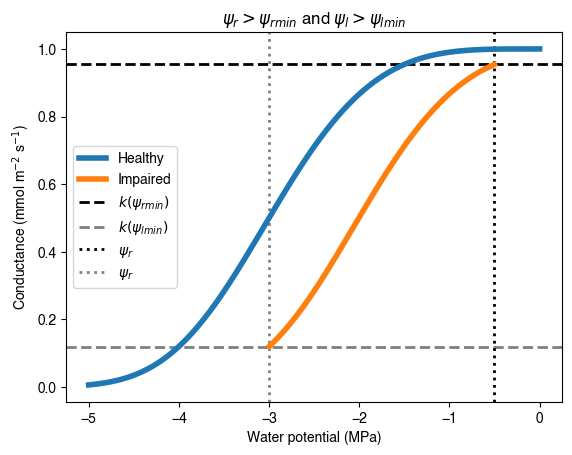

In [9]:
# Set up the system
psi_r = -0.5
psi_l = -3.
psi_rmin = -1.5
psi_lmin = -4.

# Create the healthy conductance curve
psi_healthy = np.linspace(0., -5., 1000)
k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)

# Create the historic minimum conductance values
psi_historic, k_historic, __ = calc_height_dependencies(psi_rmin, 
                                                        psi_lmin, 
                                                        N_points, 
                                                        k_max, 
                                                        shape, 
                                                        scale)

# Calculate the impaired conductance curve
psi_impaired, k_impaired, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                   psi_l, 
                                                                   N_points, 
                                                                   k_max, 
                                                                   shape, 
                                                                   scale,
                                                                   k_historic)

Plot_impaired_vulnerability_curve(psi_healthy, 
                                  k_healthy, 
                                  0.5*(psi_impaired[:-1] + psi_impaired[1:]), 
                                  k_impaired, 
                                  psi_r, psi_l, 
                                  psi_rmin, psi_lmin, 
                                  k_max, shape, scale,
                                  title = '$\psi_r > \psi_{r min}$ and $\psi_l > \psi_{l min}$')


There are four cases to consider;

$$
\psi_r > \psi_{r min} \text{ and } \psi_l > \psi_{l min}
$$ 
$$
\psi_r < \psi_{r min} \text{ and } \psi_l > \psi_{l min}
$$
$$
\psi_r > \psi_{r min} \text{ and } \psi_l < \psi_{l min}
$$
$$
\psi_r < \psi_{r min} \text{ and } \psi_l < \psi_{l min}
$$


Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


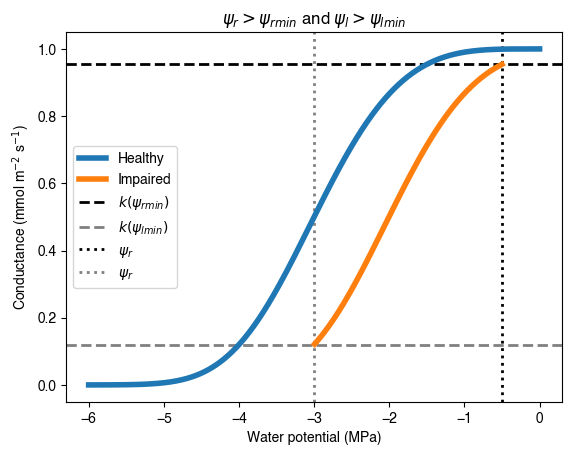

Finished at step 999999 of 1000000


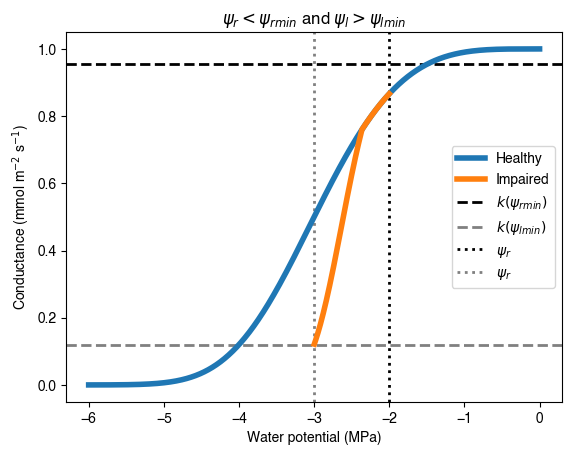

Finished at step 999999 of 1000000


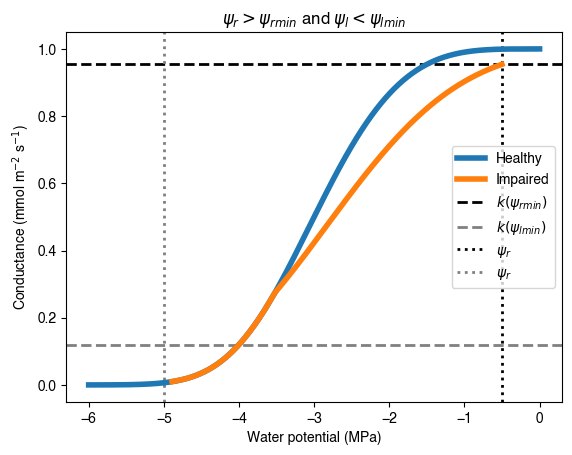

Finished at step 999999 of 1000000


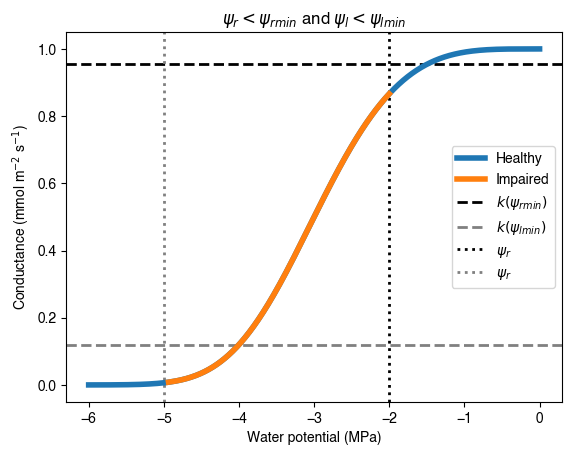

In [10]:
# -- Case 1 --
# Set up the system
psi_r = -0.5
psi_l = -3.
psi_rmin = -1.5
psi_lmin = -4.

# Create the healthy conductance curve
psi_healthy = np.linspace(0., -6., 1000)
k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)

# Create the historic minimum conductance values
psi_historic, k_historic, __ = calc_height_dependencies(psi_rmin, 
                                                        psi_lmin, 
                                                        N_points, 
                                                        k_max, 
                                                        shape, 
                                                        scale)

# Calculate the impaired conductance curve
psi_impaired, k_impaired, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                 psi_l, 
                                                                 N_points, 
                                                                 k_max, 
                                                                 shape, 
                                                                 scale,
                                                                 k_historic)

Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, 0.5*(psi_impaired[:-1] + psi_impaired[1:]), k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale,
                                  title = '$\psi_r > \psi_{r min}$ and $\psi_l > \psi_{l min}$')

# -- Case 2 --
# Set up the system
psi_r = -2.
psi_l = -3.
psi_rmin = -1.5
psi_lmin = -4.

# Calculate the impaired conductance curve
psi_impaired, k_impaired, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                 psi_l, 
                                                                 N_points, 
                                                                 k_max, 
                                                                 shape, 
                                                                 scale,
                                                                 k_historic)

Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, 0.5*(psi_impaired[:-1] + psi_impaired[1:]), k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale,
                                  title = '$\psi_r < \psi_{r min}$ and $\psi_l > \psi_{l min}$')

# -- Case 3 --
# Set up the system
psi_r = -0.5
psi_l = -5.
psi_rmin = -1.5
psi_lmin = -4.

# Calculate the impaired conductance curve
psi_impaired, k_impaired, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                 psi_l, 
                                                                 N_points, 
                                                                 k_max, 
                                                                 shape, 
                                                                 scale,
                                                                 k_historic)

Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, 0.5*(psi_impaired[:-1] + psi_impaired[1:]), k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale,
                                  title = '$\psi_r > \psi_{r min}$ and $\psi_l < \psi_{l min}$')

# -- Case 4 --
# Set up the system
psi_r = -2.
psi_l = -5.
psi_rmin = -1.5
psi_lmin = -4.

# Calculate the impaired conductance curve
psi_impaired, k_impaired, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                 psi_l, 
                                                                 N_points, 
                                                                 k_max, 
                                                                 shape, 
                                                                 scale,
                                                                 k_historic)

Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, 0.5*(psi_impaired[:-1] + psi_impaired[1:]), k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale,
                                  title = '$\psi_r < \psi_{r min}$ and $\psi_l < \psi_{l min}$')

The simplest result to interpret here is where both the leaf and root water potentials are below their previous minimum values (result 4 in red). Under these conditions the water potentials along the trunk reach a new minimum value resulting in a loss of conductance compared to the previous state. 

The results when both the leaf and root water potentials are larger than their previous minimum values (result 1 in blue) show that the water potentials along the tree are grater than their previous minimums. The water potentials along the tree trunk are hence insufficient to further reduce the conductance meaning it remains unchanged along the entirety of the trunk. By matching the conductance and watr potential values based on height we can see in the final plot how this changes the vulnerability curve, shifting the vulnerability curve imposed by the previous minimum water potentials to less negative values.

$$
k(\psi) -> k(\frac{\psi - \psi_r}{\psi_l - \psi_r}(\psi_{l, cap} - \psi_{r, cap}) + \psi_{r, cap})
$$

Where only one of the root or leaf water potentials drop below the previous minimum value (results 2 in yellow and 3 in green respectively) the results show a hybrid between the two cases above. There is a clear transition point where the new water potentials inside the tree switch between being higher than the previous minimum values and being less than them. 

# Analytic model of damage
When modeling the full tree including the code above would be very expensive, instead we want an analytic version of the model. To do this let us first consider the conductance at the leaf water potential. The conductance at the leaf is the minimum of, the past minimum conductance at the leaf or the conductance of the current leaf water potential.

$$
k_{impaired}(\psi_l) = k(\text{min}(\psi_l, \psi_{l min}))
$$

The same is true for the root where the conductance is equal to the minimum of, the conductance of the past minimum root water potential or the conductance of the current root water potential. This essentially bookends the impaired conductance curve $k_{impaired}(\psi)$.

$$
k_{impaired}(\psi_r) = k(\text{min}(\psi_r, \psi_{r min}))
$$

To calculate transpiration we need the full impaired conductance curve as a function of water potential between the leaf and root water potentials. To achieve this we are going to map the healthy conductance curve over the range $[\psi_{r min}, \psi_{l min}]$ to the range $[\psi_r, \psi_l]$ to creat the impaired conductance curve.

$$
k_{impaired}(\psi) = k(\frac{\psi - \psi_r}{\psi_l - \psi_r}(\text{min}(\psi_l, \psi_{l min}) - \text{min}(\psi_r, \psi_{r min})) + \text{min}(\psi_r, \psi_{r min}))
$$

Let's quickly code this up and plot the result.

In [11]:
def impaired_conductance(psi, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale):
    
    # First update the historic minimum values
    psi_rmin = min(psi_rmin, psi_r)
    psi_lmin = min(psi_lmin, psi_l)
    
    # Calculate the scaled water potentials
    psi_scaled = ((psi - psi_r) / (psi_l - psi_r)) * (psi_lmin - psi_rmin) + psi_rmin
    
    # Calculate the conductance
    k_impaired = cumulative_Weibull_distribution(psi_scaled, k_max, shape, scale)
    
    return k_impaired, psi_rmin, psi_lmin

# Set up the system
psi_r = -0.5
psi_l = -3.
psi_rmin = -2.
psi_lmin = -4.

# Create the water potential range
psi_healthy = np.linspace(0., -6., 1000)
psi_impaired = np.linspace(psi_r, psi_l, 1000)

k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)
k_impaired, psi_rmin, psi_lmin = impaired_conductance(psi_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

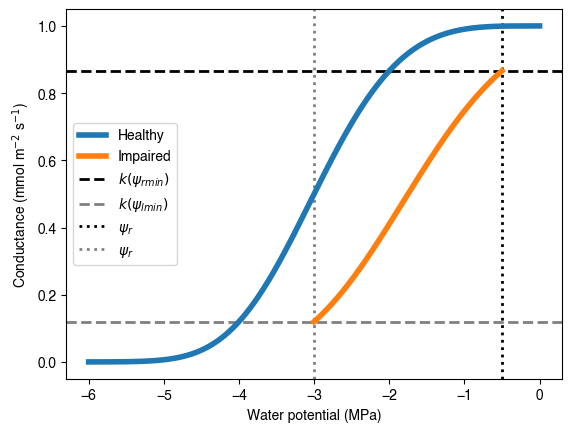

In [12]:
Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, psi_impaired, k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

To test if this is working lets plot the results for the four cases we considered previously;
$$
\psi_r > \psi_{r min} \text{ and } \psi_l > \psi_{l min}
$$ 
$$
\psi_r < \psi_{r min} \text{ and } \psi_l > \psi_{l min}
$$
$$
\psi_r > \psi_{r min} \text{ and } \psi_l < \psi_{l min}
$$
$$
\psi_r < \psi_{r min} \text{ and } \psi_l < \psi_{l min}
$$

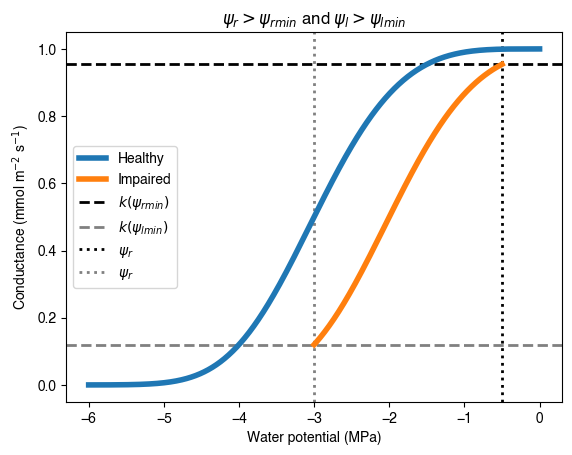

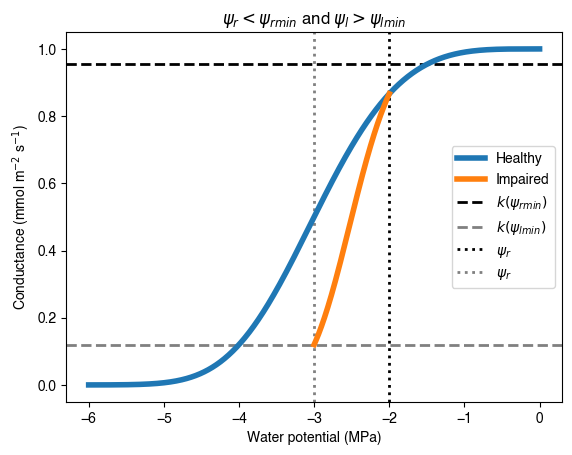

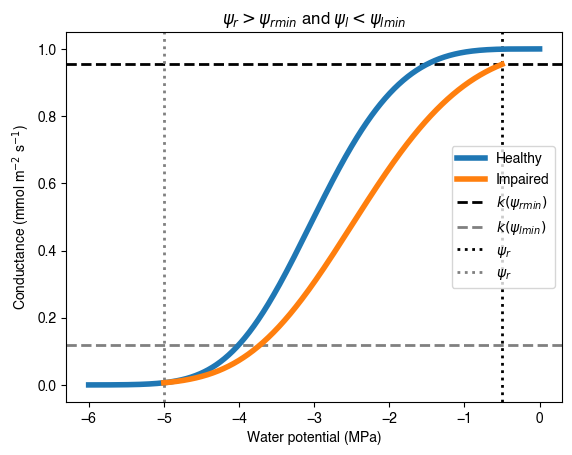

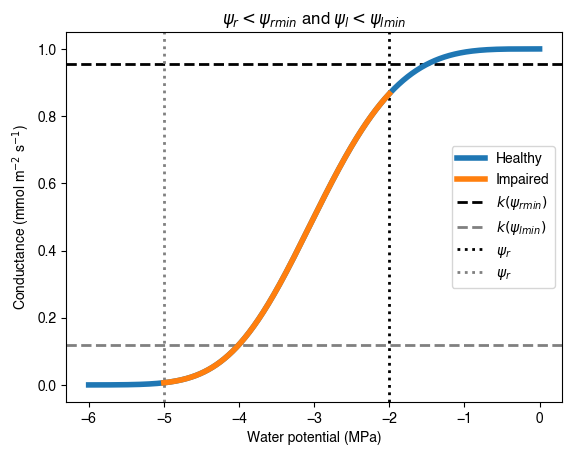

In [13]:
# -- Case 1 --
# Set up the system
psi_r = -0.5
psi_l = -3.
psi_rmin = -1.5
psi_lmin = -4.

# Create the water potential range
psi_healthy = np.linspace(0., -6., 1000)
psi_impaired = np.linspace(psi_r, psi_l, 1000)

k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)
k_impaired, __, __ = impaired_conductance(psi_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, psi_impaired, k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale,
                                  title = '$\psi_r > \psi_{r min}$ and $\psi_l > \psi_{l min}$')

# -- Case 2 --
# Set up the system
psi_r = -2.
psi_l = -3.
psi_rmin = -1.5
psi_lmin = -4.

# Create the water potential range
psi_healthy = np.linspace(0., -6., 1000)
psi_impaired = np.linspace(psi_r, psi_l, 1000)

k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)
k_impaired, __, __  = impaired_conductance(psi_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, psi_impaired, k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale,
                                  title = '$\psi_r < \psi_{r min}$ and $\psi_l > \psi_{l min}$')

# -- Case 3 --
# Set up the system
psi_r = -0.5
psi_l = -5.
psi_rmin = -1.5
psi_lmin = -4.

# Create the water potential range
psi_healthy = np.linspace(0., -6., 1000)
psi_impaired = np.linspace(psi_r, psi_l, 1000)

k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)
k_impaired, __, __  = impaired_conductance(psi_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, psi_impaired, k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale,
                                  title = '$\psi_r > \psi_{r min}$ and $\psi_l < \psi_{l min}$')

# -- Case 4 --
# Set up the system
psi_r = -2.
psi_l = -5.
psi_rmin = -1.5
psi_lmin = -4.

# Create the water potential range
psi_healthy = np.linspace(0., -6., 1000)
psi_impaired = np.linspace(psi_r, psi_l, 1000)

k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)
k_impaired, __, __  = impaired_conductance(psi_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

Plot_impaired_vulnerability_curve(psi_healthy, k_healthy, psi_impaired, k_impaired, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale,
                                  title = '$\psi_r < \psi_{r min}$ and $\psi_l < \psi_{l min}$')

## Comparing the analytic and numerical models
Let's check the accuracy of the analytic model in replicating the numerical one.

In [14]:
def Plot_comparison_of_impaired_vulnerability_curve(psi_healthy, k_healthy, psi_impaired, k_impaired_20nalytic, k_impaired_numeric, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale, title = ''):
    
    fig, axs = plt.subplots(nrows=2, sharex=True, height_ratios=[2, 1])
    
    # Plot vulnerability curves
    axs[0].plot(psi_healthy, k_healthy, label='Healthy', linewidth=4, zorder=1)
    
    axs[0].plot(psi_impaired, k_impaired_20nalytic, label='analytic', linewidth = 4, zorder=1)
    axs[0].plot(psi_impaired, k_impaired_numeric, label='numerical', linewidth = 4, zorder=1)
    
    # Calculate and plot conductance limits
    k_root = cumulative_Weibull_distribution(psi_rmin, k_max, shape, scale)
    k_leaf = cumulative_Weibull_distribution(psi_lmin, k_max, shape, scale)

    axs[0].axhline(k_root, label = '$k(\psi_{r min})$', color = 'black', linestyle='--', linewidth=2, zorder=0)
    axs[0].axhline(k_leaf, label = '$k(\psi_{l min})$', color = 'grey', linestyle='--', linewidth=2, zorder=0)
    
    # Plot the water potential limits
    axs[0].axvline(psi_r, label = '$\psi_r$', color = 'black', linestyle=':', linewidth=2, zorder=0)
    axs[0].axvline(psi_l, label = '$\psi_r$', color = 'grey', linestyle=':', linewidth=2, zorder=0)
    
    axs[1].axvline(psi_r, label = '$\psi_r$', color = 'black', linestyle=':', linewidth=2, zorder=0)
    axs[1].axvline(psi_l, label = '$\psi_r$', color = 'grey', linestyle=':', linewidth=2, zorder=0)
    
    #Plot the residuals of the analytic model
    axs[1].plot(psi_impaired, k_impaired_20nalytic - k_impaired_numeric, color='red', linewidth = 4, zorder=1)
    
    axs[1].axhline(0, color = 'black', linewidth=1, zorder=0)
    
    # Format the plots
    axs[1].set_ylim(-0.15, 0.02)
    fig.subplots_20djust(hspace=0)
    axs[1].set_xlabel('Water potential (MPa)')
    axs[0].set_ylabel('Conductance (mmol m$^{-2}$ s$^{-1}$)')
    axs[1].set_ylabel('Analytic to Numeric \n Residual (mmol m$^{-2}$ s$^{-1}$)')
    axs[0].legend()
    axs[0].set_title(title)
    plt.show()
    

Finished at step 999999 of 1000000
Finished at step 999999 of 1000000


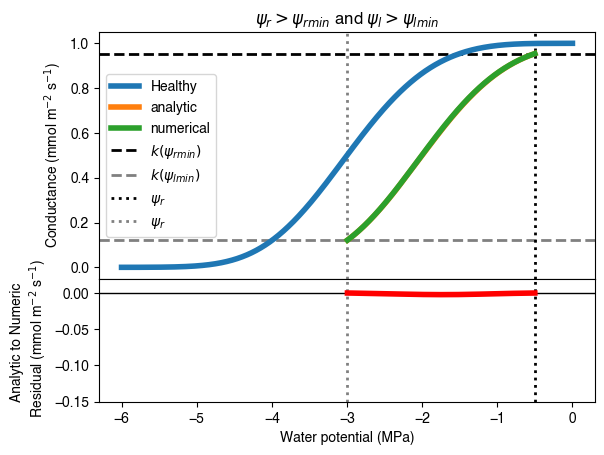

Finished at step 999999 of 1000000


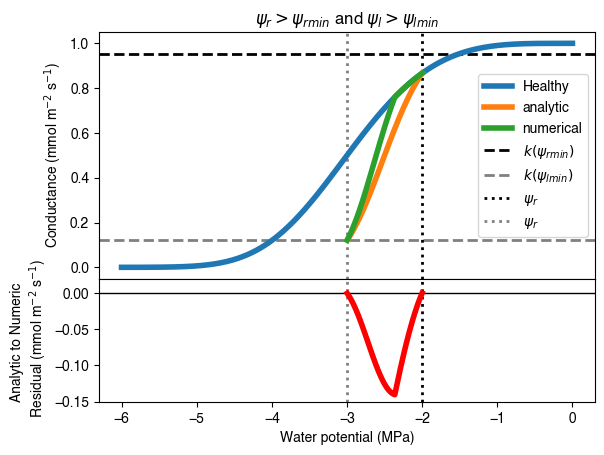

Finished at step 999999 of 1000000


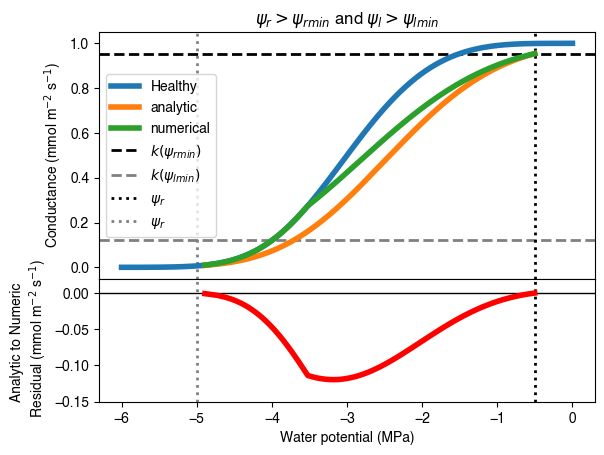

Finished at step 999999 of 1000000


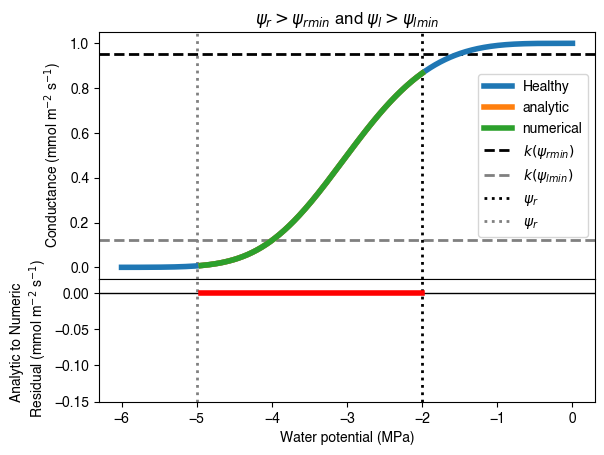

In [16]:
# -- Case 1 --
# Set up the system
psi_r = -0.5
psi_l = -3.
psi_rmin = -1.5
psi_lmin = -4.

# Create the healthy conductance curve
psi_healthy = np.linspace(0., -6., 1000)
k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)

# Create the historic minimum conductance values
psi_historic, k_historic, __ = calc_height_dependencies(psi_rmin, 
                                                        psi_lmin, 
                                                        N_points, 
                                                        k_max, 
                                                        shape, 
                                                        scale)

# Calculate the impaired conductance curve
psi_impaired_numeric, k_impaired_numeric, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                                   psi_l, 
                                                                                   N_points, 
                                                                                   k_max, 
                                                                                   shape, 
                                                                                   scale,
                                                                                   k_historic)

# Needed to match the size of the conductance array
psi_impaired_numeric = 0.5*(psi_impaired_numeric[:-1] + psi_impaired_numeric[1:])

k_impaired_20nalytic, __, __ = impaired_conductance(psi_impaired_numeric, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

Plot_comparison_of_impaired_vulnerability_curve(psi_healthy, k_healthy, 
                                                psi_impaired_numeric, 
                                                k_impaired_20nalytic,
                                                k_impaired_numeric, 
                                                psi_r, psi_l, psi_rmin, psi_lmin, 
                                                k_max, shape, scale,
                                                title = '$\psi_r > \psi_{r min}$ and $\psi_l > \psi_{l min}$')

# -- Case 2 --
# Set up the system
psi_r = -2
psi_l = -3.
psi_rmin = -1.5
psi_lmin = -4.

# Calculate the impaired conductance curve
psi_impaired_numeric, k_impaired_numeric, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                                   psi_l, 
                                                                                   N_points, 
                                                                                   k_max, 
                                                                                   shape, 
                                                                                   scale,
                                                                                   k_historic)

# Needed to match the size of the conductance array
psi_impaired_numeric = 0.5*(psi_impaired_numeric[:-1] + psi_impaired_numeric[1:])

k_impaired_20nalytic, __, __ = impaired_conductance(psi_impaired_numeric, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

Plot_comparison_of_impaired_vulnerability_curve(psi_healthy, k_healthy, 
                                                psi_impaired_numeric, 
                                                k_impaired_20nalytic,
                                                k_impaired_numeric, 
                                                psi_r, psi_l, psi_rmin, psi_lmin, 
                                                k_max, shape, scale,
                                                title = '$\psi_r > \psi_{r min}$ and $\psi_l > \psi_{l min}$')

# -- Case 3 --
# Set up the system
psi_r = -0.5
psi_l = -5.
psi_rmin = -1.5
psi_lmin = -4.

# Calculate the impaired conductance curve
psi_impaired_numeric, k_impaired_numeric, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                                   psi_l, 
                                                                                   N_points, 
                                                                                   k_max, 
                                                                                   shape, 
                                                                                   scale,
                                                                                   k_historic)

# Needed to match the size of the conductance array
psi_impaired_numeric = 0.5*(psi_impaired_numeric[:-1] + psi_impaired_numeric[1:])

k_impaired_20nalytic, __, __ = impaired_conductance(psi_impaired_numeric, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

Plot_comparison_of_impaired_vulnerability_curve(psi_healthy, k_healthy, 
                                                psi_impaired_numeric, 
                                                k_impaired_20nalytic,
                                                k_impaired_numeric, 
                                                psi_r, psi_l, psi_rmin, psi_lmin, 
                                                k_max, shape, scale,
                                                title = '$\psi_r > \psi_{r min}$ and $\psi_l > \psi_{l min}$')

# -- Case 4 --
# Set up the system
psi_r = -2
psi_l = -5.
psi_rmin = -1.5
psi_lmin = -4.

# Calculate the impaired conductance curve
psi_impaired_numeric, k_impaired_numeric, __ = calc_height_dependencies_impaired_k(psi_r, 
                                                                                   psi_l, 
                                                                                   N_points, 
                                                                                   k_max, 
                                                                                   shape, 
                                                                                   scale,
                                                                                   k_historic)

# Needed to match the size of the conductance array
psi_impaired_numeric = 0.5*(psi_impaired_numeric[:-1] + psi_impaired_numeric[1:])

k_impaired_20nalytic, __, __ = impaired_conductance(psi_impaired_numeric, psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)

Plot_comparison_of_impaired_vulnerability_curve(psi_healthy, k_healthy, 
                                                psi_impaired_numeric, 
                                                k_impaired_20nalytic,
                                                k_impaired_numeric, 
                                                psi_r, psi_l, psi_rmin, psi_lmin, 
                                                k_max, shape, scale,
                                                title = '$\psi_r > \psi_{r min}$ and $\psi_l > \psi_{l min}$')

# Percentage loss of conductance
While we could calculate the PLC using the conductance at the leaf water potential this would fail to capture the loss of conductance throughout the rest of the tree, in particular at the roots. To get an accurate descriptor of conductance over the whole tree we calculate the average conductance as;

$$
\bar{k_{impaired}} = \frac{1}{\psi_l - \psi_r} \int_{\psi_r}^{\psi_l} k_{impaired}(\psi) d\psi
$$

The PLC is then given by this mean conductance over the maximum conductance ($k_{max}$);

$$
PLC = 100 \times (1 - \frac{\bar{k_{impaired}}}{k_{max}})
$$

Using the equation for the mean conductance we find that this method of calculating the PLC can be rewritten using the transpiration rates;

$$
PLC = 100 \times (1 - \frac{E_{impaired}(\psi_r, \psi_l)}{E_{max}(\psi_r, \psi_l)})
$$

Where $E_{max}(\psi_r, \psi_l)$ is the maximum transpiration rate, achieved when the conductance of the whole tree is equal to $k_{max}$.

If we use the analytic model of $k_{impaired}(\psi)$ to calculate $\bar{k_{impaired}}$ we can rewrite the integral for the mean conductance as;

$$
\bar{k_{impaired}} = \frac{1}{\text{min}(\psi_l, \psi_{l min}) - \text{min}(\psi_r, \psi_{r min})} \int_{\text{min}(\psi_r, \psi_{r min})}^{\text{min}(\psi_l, \psi_{l min})} k_(\psi) d\psi
$$

The equation for the PLC then becomes;

$$
PLC = 100 \times (1 - \frac{\int_{\text{min}(\psi_r, \psi_{r min})}^{\text{min}(\psi_l, \psi_{l min})} k_(\psi) d\psi}{k_{max}(\text{min}(\psi_l, \psi_{l min}) - \text{min}(\psi_r, \psi_{r min}))} )
$$

Writing the calculation of the PLC in this way shows, through the presence of $min(\psi_l, \psi_{l min})$ and $min(\psi_r, \psi_{r min})$, that the PLC is entirely dependent on the most extreme leaf and root water potentials. The PLC only depends on the current leaf and or root water potentials if they are a new extreme.

Let's write a function to calculate the PLC

In [37]:
def PLC(psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale):
    
    # Identify the most extreme water potentials
    psi_rmin = np.min([psi_r, psi_rmin])
    psi_lmin = np.min([psi_l, psi_lmin])
    
    # Calculate the maximum transpiration rate
    k_max_integrated = k_max * (psi_lmin - psi_rmin)
    
    # Calculate the impaired transpiration rate
    psi_values = np.linspace(psi_rmin, psi_lmin, 1000)
    k_impaired_values = cumulative_Weibull_distribution(psi_values, k_max, shape, scale)
    k_impaired_intergrated = np.trapz(k_impaired_values, psi_values)
    
    # Calculate the PLC
    return 100 * (1 - k_impaired_intergrated / k_max_integrated)

In [38]:
# Set up the system
psi_r = -0.5
psi_l = -3.
psi_rmin = -1.5
psi_lmin = -4.

plc_value = PLC(psi_r, psi_l, psi_rmin, psi_lmin, k_max, shape, scale)
print('PLC =', plc_value, '%')

PLC = 41.93924559177719 %


## Mapping the PLC
Now we have a method for calculating the PLC we can look at how it depends on the extream leaf and root water potentials.

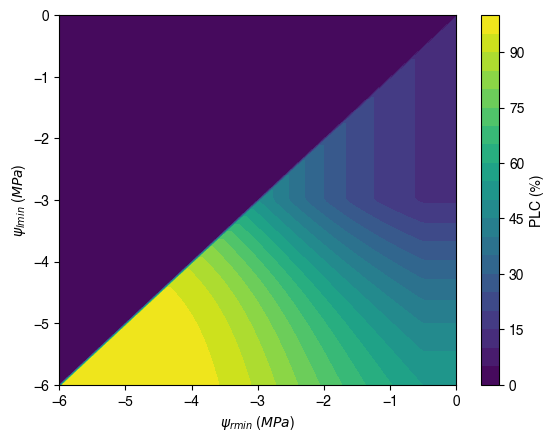

In [39]:
psi_rmin_Array = np.linspace(-6., -0., 100)
psi_lmin_Array = np.linspace(-6., -0., 100)

PLC_values = np.zeros((len(psi_rmin_Array), len(psi_lmin_Array)))

for i in range(len(psi_rmin_Array)):
    for j in range(len(psi_lmin_Array)):
        # psi_lmin must be less than psi_rmin for this to be physicaly meaningfull
        if(psi_lmin_Array[j] - psi_rmin_Array[i] < -0.01):
            PLC_values[i,j] = PLC(psi_r, psi_l, psi_rmin_Array[i], psi_lmin_Array[j], k_max, shape, scale)

# Plot the results
plt.contourf(psi_rmin_Array, psi_lmin_Array, PLC_values.T, levels=20, vmin = 0, vmax = 100)

plt.colorbar(label = 'PLC (%)')

# Format the figure
plt.xlabel("$\psi_{r min}$ ($MPa$)")
plt.ylabel("$\psi_{l min}$ ($MPa$)")
plt.show()

# Plot for Martin
Plot of the vulnerability curves for two PLC values $20\%$ and $80\%$.

PLC_20 = 20.99989413257398 %
PLC_60 = 60.664968505381886 %


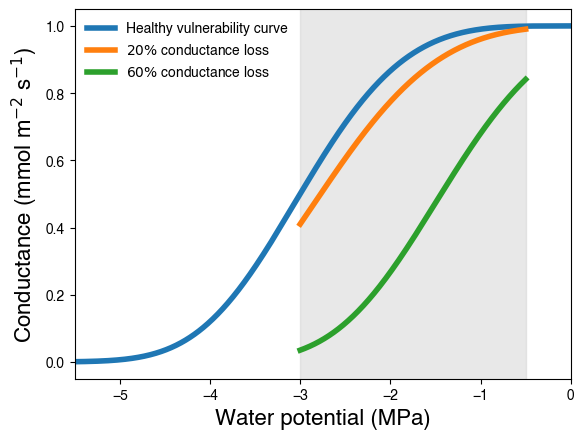

In [71]:
# -- 20% PLC --
# Set up the system
psi_r = -0.5
psi_l = -3.0
psi_rmin_20 = -1.0
psi_lmin_20 = -3.2

# calculate the PLC to check the minimum values are correct
plc_20 = PLC(psi_r, psi_l, psi_rmin_20, psi_lmin_20, k_max, shape, scale)
print('PLC_20 =', plc_20, '%')

# -- 60% PLC --
# Set up the system
psi_rmin_60 = -2.1
psi_lmin_60 = -4.5

# calculate the PLC to check the minimum values are correct
plc_60 = PLC(psi_r, psi_l, psi_rmin_60, psi_lmin_60, k_max, shape, scale)
print('PLC_60 =', plc_60, '%')

# Create the water potential range
psi_healthy = np.linspace(0., -5.5, 1000)
psi_impaired = np.linspace(psi_r, psi_l, 1000)

# Calculate conductance's
k_healthy = cumulative_Weibull_distribution(psi_healthy, k_max, shape, scale)
k_impaired_20, __, __ = impaired_conductance(psi_impaired, psi_r, psi_l, psi_rmin_20, psi_lmin_20, k_max, shape, scale)
k_impaired_60, __, __ = impaired_conductance(psi_impaired, psi_r, psi_l, psi_rmin_60, psi_lmin_60, k_max, shape, scale)

# Plot the results
plt.plot(psi_healthy, k_healthy,      label='Healthy vulnerability curve', linewidth=4, zorder=1)
plt.plot(psi_impaired, k_impaired_20, label='$20\%$ conductance loss', linewidth = 4, zorder=1)
plt.plot(psi_impaired, k_impaired_60, label='$60\%$ conductance loss', linewidth = 4, zorder=1)

# Add grey patch to show trees operating range
plt.fill_between([psi_r, psi_l], -1, 2, color='lightgrey', alpha=0.5, zorder=0)

# Format figure
plt.legend(frameon = False)

plt.xlabel('Water potential (MPa)', fontsize=16)
plt.ylabel('Conductance (mmol m$^{-2}$ s$^{-1}$)', fontsize=16)

plt.xlim(-5.5,0)
plt.ylim(-0.05, 1.05)
plt.show()

What is the difference in transpiration, when $\psi_r = -0.5$ and $\psi_l = -3$, between the 20% and 60% PLC cases and a tree where this is a new extreme?

In [83]:
# First what is the PLC if this is a new extreme?
PLC_new_extreme = PLC(psi_r, psi_l, psi_r, psi_l, k_max, shape, scale)
print('PLC_new_extreme =', PLC_new_extreme, '%')

# What is the fraction of the maximum transpiration for each case?
frac_conductance_new_extreme = 1 - PLC_new_extreme / 100
frac_conductance_20 = 0.8
frac_conductance_60 = 0.4

# Calculate the transpiration rates
E_max = -k_max * (psi_l - psi_r)
E_new_extreme = E_max * frac_conductance_new_extreme
E_20 = E_max * frac_conductance_20
E_60 = E_max * frac_conductance_60

print(' ')
print('E_max =', E_max, 'mmol m^-2 s^-1')
print('E_new_extreme =', E_new_extreme, 'mmol m^-2 s^-1')
print('E_20 =', E_20, 'mmol m^-2 s^-1')
print('E_60 =', E_60, 'mmol m^-2 s^-1')

# What is the overprediction if we always asume a new extreme?
print(' ')
print('Overprediction of transpiration for 20% PLC =', E_new_extreme / E_20)
print('Overprediction of transpiration for 60% PLC =', E_new_extreme / E_60)

PLC_new_extreme = 14.197088541677816 %
 
E_max = 2.5 mmol m^-2 s^-1
E_new_extreme = 2.1450727864580545 mmol m^-2 s^-1
E_20 = 2.0 mmol m^-2 s^-1
E_60 = 1.0 mmol m^-2 s^-1
 
Overprediction of transpiration for 20% PLC = 1.0725363932290273
Overprediction of transpiration for 60% PLC = 2.1450727864580545
